In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import mra

In [2]:
plt.rcParams['text.usetex'] = True
np.random.seed(123)
random.seed(123)

# Create parameters

In [3]:
rho = 1.
num_points = [10, 50]
eps_sublevel = percent = 0.1

alpha = 1 # proximal term coefficient

num_agents = num_commodities = 100

filename = "mcf_N%s_%.2f_n%d"%(",".join(list(map(str, num_points))), eps_sublevel, num_agents)

In [4]:
num_vertices = 15
num_edges = 100

params, A_ineq, b_ineq = mra.mcf_data(num_vertices, num_edges, num_commodities)

b_norm = np.linalg.norm(b_ineq)

# CVXPY centralized solution

In [5]:
true_x, true_f, true_lamb = mra.centralized_multi_commodity_flow(params, A_ineq, b_ineq)
print(f"{true_f=}")

true_f=-127.24864071521705


In [6]:
(true_lamb.max() - true_lamb.min()) / true_lamb.max()

0.9999999999761228

In [7]:
true_lamb.shape, true_x.shape

((100, 1), (10000, 1))

In [8]:
fun_agents_eps = []
fun_agents_noisy_y = []

for i in range(num_agents):
    fun_agents_eps += [lambda lamb_k, K, i=i: mra.mcf_query_multiple_actions(lamb_k, i, params[i], 
                                                                           eps_sublevel=eps_sublevel, K=K, return_best=True)]
    fun_agents_noisy_y += [lambda lamb_k, K, i=i: mra.mcf_query_multiple_actions_noisy_prices(lamb_k, i, params[i], percent=percent, K=K)]

fun_obj_val = lambda x_k: mra.mcf_obj_value(x_k, params)

# Localization

In [9]:
price_max = 3 * true_lamb.max()
price_min = (1./3) * true_lamb.min()
K_i = num_points
N = num_agents
primal_var_size = A_ineq.shape[1]

In [10]:
all_results_eps = {}
all_results_noisy_y = {}
for K_i in num_points:
    print(f"{K_i=}")
    all_results_eps[K_i]  = mra.price_localization_primal_recovery(fun_agents_eps, fun_obj_val, primal_var_size, A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]


    all_results_noisy_y[K_i]  = mra.price_localization_primal_recovery(fun_agents_noisy_y, fun_obj_val, primal_var_size, 
                                                                                                      A_ineq=A_ineq, b_ineq=b_ineq, 
                                                            price_max=price_max, price_min=price_min, alpha=alpha, relaxed=True, 
                                                            postprocessing=1, K_i=K_i, num_iters=200, 
                                                            method="accpm_l2", true_f=true_f, print_freq=50, eps_lamb=1e-28,
                                                            res_type="primal_compl_slack", history=1)[0]

K_i=10


/Users/tepars/anaconda3/envs/py311/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)
/Users/tepars/anaconda3/envs/py311/lib/python3.11/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


epoch=0, f_prec[-1]=-46.31, f_xk[-1]=-35.28, viol_prec=1.6228E+01, viol_xk=1.6881E+01, lamb_rel_diff=0.0000E+00, dist_x_bar_x[-1]=7.6858E-01
epoch=50, f_prec[-1]=-132.88, f_xk[-1]=-135.25, viol_prec=9.2772E-01, viol_xk=2.9238E+00, lamb_rel_diff=4.8992E-02, dist_x_bar_x[-1]=5.6918E-01
epoch=100, f_prec[-1]=-127.77, f_xk[-1]=-127.84, viol_prec=1.1526E+00, viol_xk=1.9980E+00, lamb_rel_diff=3.5822E-02, dist_x_bar_x[-1]=2.2655E-01
epoch=150, f_prec[-1]=-128.47, f_xk[-1]=-128.40, viol_prec=1.7024E+00, viol_xk=2.0220E+00, lamb_rel_diff=3.0697E-02, dist_x_bar_x[-1]=3.2979E-01
epoch=199, f_prec[-1]=-126.96, f_xk[-1]=-126.82, viol_prec=1.3991E+00, viol_xk=1.7555E+00, lamb_rel_diff=2.3946E-02, dist_x_bar_x[-1]=2.3454E-01
epoch=0, f_prec[-1]=-38.30, f_xk[-1]=-35.28, viol_prec=1.6720E+01, viol_xk=1.6881E+01, lamb_rel_diff=0.0000E+00, dist_x_bar_x[-1]=7.3000E-01
epoch=50, f_prec[-1]=-132.49, f_xk[-1]=-135.25, viol_prec=9.3639E-01, viol_xk=2.9238E+00, lamb_rel_diff=4.8992E-02, dist_x_bar_x[-1]=4.3232

In [11]:
K_i = min(num_points)
if len(all_results_noisy_y[K_i]["subopt_xk"]) > len(all_results_eps[K_i]["subopt_xk"]):
    all_res = all_results_noisy_y[K_i]
else:
    all_res = all_results_eps[K_i]

In [13]:
for i, K_i in enumerate(num_points):
      print(np.array(all_res["viol_primal_xk"])[-1] / b_norm,
      "sub_eps", np.array(all_results_eps[K_i]["viol_primal_mra_xk"])[-1] / b_norm,
      "noisy_y", np.array(all_results_noisy_y[K_i]["viol_primal_mra_xk"])[-1] / b_norm)

1.0054247232538476 sub_eps 0.8043723750352413 noisy_y 3.3878751821797506e-07
1.0054247232538476 sub_eps 0.7280020116337362 noisy_y 5.271156985403609e-07


In [ ]:
import pickle

with open(f"results/{filename}_dict.pkl", "wb") as file:
    pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)

In [6]:
import pickle

# with open(f"results/{filename}_dict.pkl", "wb") as file:
#     pickle.dump({"eps":all_results_eps, "noisy_y":all_results_noisy_y}, file)
with open(f"results/{filename}_dict.pkl", "rb") as file:
    res = pickle.load(file)
    all_results_eps = res["eps"]
    all_results_noisy_y = res["noisy_y"]
    K_i = min(num_points)
    if len(all_results_noisy_y[K_i]["subopt_xk"]) > len(all_results_eps[K_i]["subopt_xk"]):
        all_res = all_results_noisy_y[K_i]
    else:
        all_res = all_results_eps[K_i]
# res["eps"].keys()

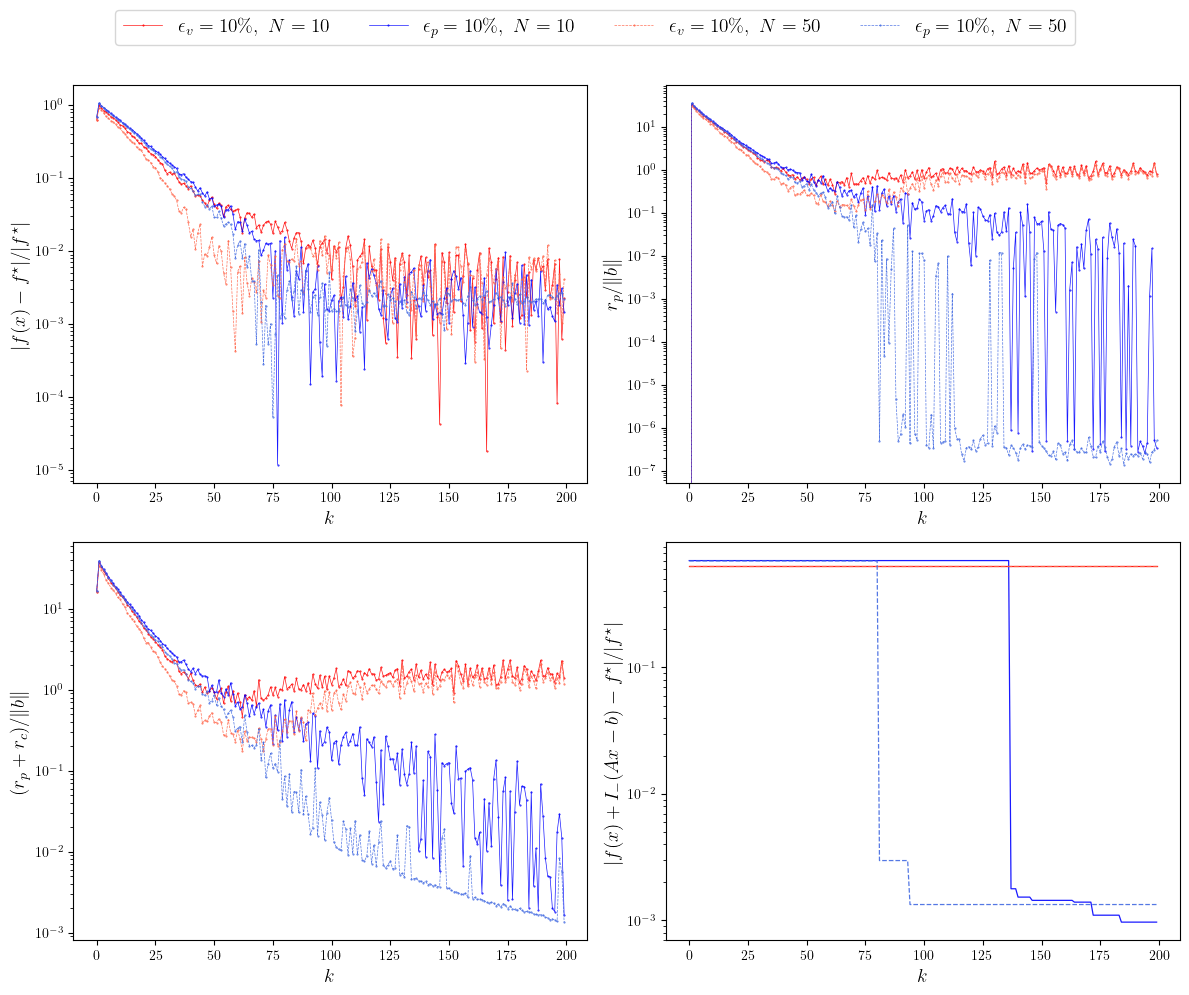

In [8]:
mra.plot_N_all_metrics_4x(all_results_eps, all_results_noisy_y, eps_sublevel, true_f, 
                                b_norm, num_points, filename)

In [9]:
for K_i in num_points:
    print(f"{K_i=}")
    eps_subopt = (np.abs(np.array(all_results_eps[K_i]["f_prec"]) - true_f)) / np.abs(true_f)
    eps_res = np.array(all_results_eps[K_i]["viol_primal_mra_xk"]) / b_norm
    noisy_y_subopt = (np.abs(np.array(all_results_noisy_y[K_i]["f_prec"]) - true_f)) / np.abs(true_f)
    noisy_y_res = np.array(all_results_noisy_y[K_i]["viol_primal_mra_xk"]) / b_norm

    res_tol = 1e-6
    print("eps", np.where(eps_res < res_tol)[0][0],  "noisy_y", np.where(noisy_y_res[1:] < res_tol)[0][0]+1)

    eps_subopt = np.array(mra.subopt_of_best_feas_point_only(all_results_eps[K_i], true_f, b_norm),)
    noisy_y_subopt = np.array(mra.subopt_of_best_feas_point_only(all_results_noisy_y[K_i], true_f, b_norm),)

    print("eps", eps_subopt[-1]*100,  "noisy_y", noisy_y_subopt[-1]*100)

K_i=10
eps 0 noisy_y 137
eps 63.60870574981984 noisy_y 0.09707561790687771
K_i=50
eps 0 noisy_y 81
eps 63.56347108823924 noisy_y 0.13371319377503849
